# Reading Android Logger Data

The first thing we need to do is download `gnss_lib_py`. The nice thing about Google Colab is that once we run this cell once, we never have to run it again.

In [1]:
# install gnss_lib_py
%pip install gnss_lib_py --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 1.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.1/106.1 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.1 MB/s eta 0:0

We then load all modules that we'll need in this notebook

In [2]:
# import gnss_lib_py
import numpy as np
import gnss_lib_py as glp
import matplotlib.pyplot as plt

In [3]:
# file name <--- Replace with your own file!
file_rinex = "/content/gnss_log_2024_11_21_12_57_35.24o"
file_nmea = "/content/gnss_log_2024_11_21_12_57_35.nmea"
file_txt = "/content/gnss_log_2024_11_21_12_57_35.txt"

## Fix Positions
First, get the fix positions and plot them on a map

In [4]:
fix_data = glp.AndroidRawFixes(file_txt)

fix_types = np.unique(fix_data["fix_provider"]).tolist()

fixes = []
for provider in fix_types:
    fix_provider = fix_data.where("fix_provider",provider)
    fix_provider.rename({"lat_rx_deg":"lat_rx_" + provider + "_deg",
                         "lon_rx_deg":"lon_rx_" + provider + "_deg",
                         "alt_rx_m":"alt_rx_" + provider + "_m",
                         }, inplace=True)
    fixes.append(fix_provider)

fig_fix = glp.plot_map(*fixes)
fig_fix.show()

## Processing Function
Below is the function to process the obtained Android data

In [10]:
from datetime import datetime
from pytz import timezone

# parameters to change #<----- change this!!!
textfile_date = datetime(2024, 11, 21, 12, 57, 35, tzinfo=timezone('America/Los_Angeles'))
offset_ms = 392.32 * 1000   # additional offset #400 worked (ish)
use_precise = True      # use precise epehmeris (only available 1 week after meas)

# load raw data
def process_data(offset_ms, use_precise=False):
    raw_data = glp.AndroidRawGnss(input_path=file_txt,
                                  filter_measurements=True,
                                  measurement_filters={"sv_time_uncertainty" : 500.},
                                  verbose=True)

    # first correct to the roughly correct time
    gps_millisec_logged = raw_data["gps_millis"][0]
    datetime_logged = glp.gps_millis_to_datetime(raw_data["gps_millis"])[0]
    true_gpsmillisec = glp.datetime_to_gps_millis(textfile_date)

    diff_gps_millisec = gps_millisec_logged - true_gpsmillisec
    raw_data["gps_millis"] = raw_data["gps_millis"] - diff_gps_millisec   # correct to the log file date

    print("datetime (logged):", datetime_logged)
    print("gps_millis (logged): {0:4.2e}".format(gps_millisec_logged))
    print("gps_millis (log file time): {0:4.2e}".format(true_gpsmillisec))

    # additional offset to the gps millisec
    offset_data = raw_data.copy()
    offset_data["gps_millis"] = raw_data["gps_millis"] + offset_ms

    # extract gps states
    if use_precise:
      derived_sv_states = glp.add_sv_states(offset_data, source="precise", verbose=False)
      print(derived_sv_states)
    else:
      derived_gps = offset_data.where("gnss_id", "gps")
      sv_state_rows = ['x_sv_m', 'y_sv_m', 'z_sv_m', 'vx_sv_mps', 'vy_sv_mps', 'vz_sv_mps', 'b_sv_m']
      derived_sv_states = glp.add_sv_states_rinex(derived_gps)

    # correct satellite clock bias
    full_states = derived_sv_states.copy()
    full_states["corr_pr_m"] = full_states["raw_pr_m"] \
                            + full_states['b_sv_m']
    full_states = full_states.where("gnss_id", "gps")   # use only gps

    # remove all data with raw_pr_m > 1e8
    full_states = full_states.where("raw_pr_m", 3e7, "leq")
    glp.plot_metric_by_constellation(full_states, "gps_millis", "raw_pr_m")

    # solve weighted least squares
    full_states["weights"] = 1./full_states["raw_pr_sigma_m"]**2
    wls_estimate = glp.solve_wls(full_states)

    return wls_estimate, full_states


sv_time_uncertainty removed 102
datetime (logged): 2024-11-21 20:57:07.445000+00:00
gps_millis (logged): 1.42e+12
gps_millis (log file time): 1.42e+12
      # Raw    unix_millis     TimeNanos  LeapSecond  TimeUncertaintyNanos  \
0       Raw  1732222627445  113716000000         NaN                   NaN   
1       Raw  1732222627445  113716000000         NaN                   NaN   
2       Raw  1732222627445  113716000000         NaN                   NaN   
3       Raw  1732222627445  113716000000         NaN                   NaN   
4       Raw  1732222627445  113716000000         NaN                   NaN   
...     ...            ...           ...         ...                   ...   
10170   Raw  1732223121445  607716000000         NaN                   NaN   
10171   Raw  1732223121445  607716000000         NaN                   NaN   
10172   Raw  1732223121445  607716000000         NaN                   NaN   
10173   Raw  1732223121445  607716000000         NaN                 

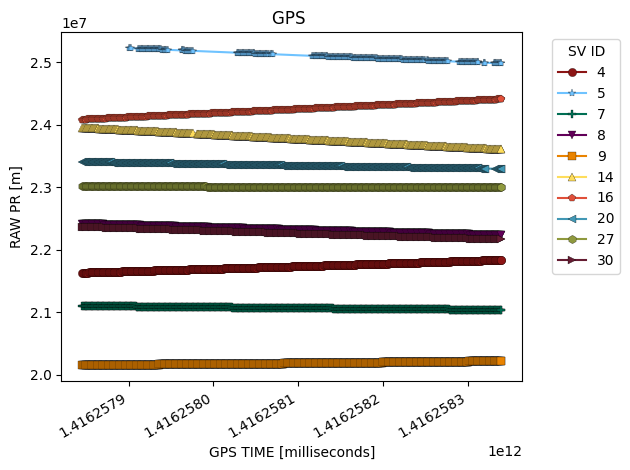

In [12]:
full_states = process_data(offset_ms, use_precise)[1]
#print(full_states)

In [13]:
import pandas as pd
if isinstance(full_states, dict):
    df = pd.DataFrame(full_states)
else:
    df = full_states

# Save the DataFrame to a CSV file
csv_file_path = "full_states.csv"  # Define the output file name
df.to_csv(csv_file_path, index=False)

print(f"Data has been saved to {csv_file_path}")

Data has been saved to full_states.csv


## Estimated Position without offset
Due to some internal software errors, the Android receivers gps_millisec could be in a shifted epoch (2005/04/05 in this case). This will result in a different satellite position and threfore incorrect position estimate

sv_time_uncertainty removed 102
datetime (logged): 2024-11-21 20:57:07.445000+00:00
gps_millis (logged): 1.42e+12
gps_millis (log file time): 1.42e+12


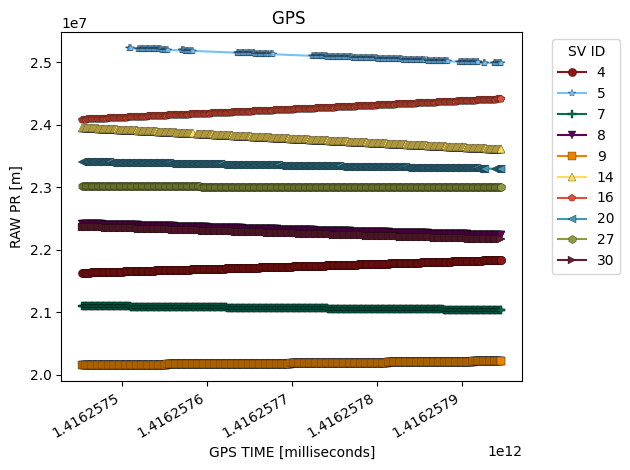

In [6]:
wls_estimate = process_data(0.0, False)
raw_fig = glp.plot_map(wls_estimate)
raw_fig.show()

## Estimated Position with Time Offset
We can fix this issue by adding a manual offset to the recorded gps_millisec
It will operate in two stages
- First shift gps_millisec to the date shown in the file name
- Then, add additional time offsets (tune this) so that the WLS solution matches the position fix

sv_time_uncertainty removed 102
datetime (logged): 2024-11-21 20:57:07.445000+00:00
gps_millis (logged): 1.42e+12
gps_millis (log file time): 1.42e+12


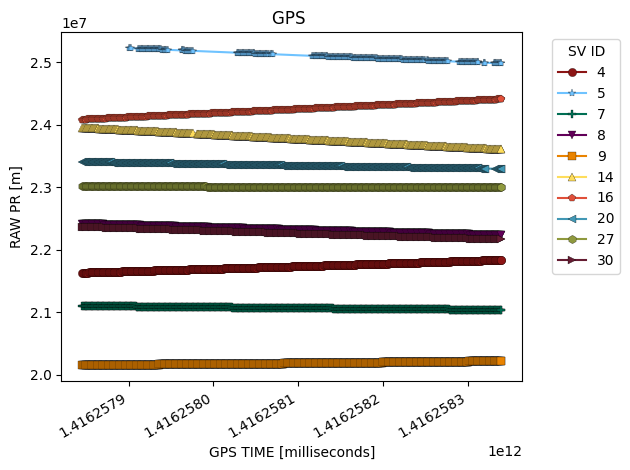

In [7]:
# with offset
wls_estimate_offset = process_data(offset_ms, use_precise)
offset_fig = glp.plot_map(wls_estimate_offset)
offset_fig.show()